<a href="https://colab.research.google.com/github/anitashar/DS-Unit-2-Linear-Models/blob/master/anita_sharma_Copy_of_LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [6]:
print(df.shape)
df.head()

(23040, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [7]:
# Just to check zero values for sale price
df['SALE_PRICE'].value_counts()

0          6909
10          199
800000      125
750000      121
650000      120
           ... 
5236177       1
229000        1
397218        1
4112000       1
1751425       1
Name: SALE_PRICE, Length: 3831, dtype: int64

In [8]:
df.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

## **Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.**

In [0]:
df_subset = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') 
               & (df['SALE_PRICE'] > 100000)
                & (df['SALE_PRICE'] < 2000000)]
df_subset = df_subset.drop(['EASE-MENT', 'APARTMENT_NUMBER'], axis = 1)

     

In [10]:
# check the shape & have a look at the data
print(df_subset.shape)
df_subset.head()

(3151, 19)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [11]:
#  check for zero again
df_subset['SALE_PRICE'].value_counts(ascending = True)

727000     1
608550     1
457000     1
672045     1
413000     1
          ..
650000    36
525000    40
450000    40
550000    43
500000    48
Name: SALE_PRICE, Length: 1000, dtype: int64

In [12]:
df_subset.isnull().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

## **Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.**

In [13]:
# check the data for date column
print(df_subset['SALE_DATE'].dtypes)
df_subset[['SALE_DATE']]

object


,SALE_DATE
44,01/01/2019
61,01/01/2019
78,01/02/2019
108,01/02/2019
111,01/02/2019
...,...
23029,04/30/2019
23031,04/30/2019
23032,04/30/2019
23033,04/30/2019


In [14]:
# change the date column string to datetype
 df_subset['SALE_DATE']=pd.to_datetime(df_subset['SALE_DATE'])
df_subset['SALE_DATE'].dtypes



dtype('<M8[ns]')

In [15]:
# check sale_date data
df_subset[['SALE_DATE']].head()

,SALE_DATE
44,2019-01-01
61,2019-01-01
78,2019-01-02
108,2019-01-02
111,2019-01-02


In [16]:
# check the years in date column
pd.unique(df_subset['SALE_DATE'].dt.year)

array([2019])

In [17]:
#We only have one year 2019, so will only extract the month.
# df_subset['MONTH'] = df_subset['SALE_DATE'].dt.month
# df_subset[['SALE_DATE','MONTH']].sample(5)
pd.unique(df_subset['SALE_DATE'].dt.month)


array([1, 2, 3, 4])

In [18]:
# create train & test data for df_subset
##Use the month from January to March to get train data
#Use the month from April to get test data
cutoff = pd.to_datetime('2019-04-01')
train = df_subset[df_subset.SALE_DATE < cutoff]
test = df_subset[df_subset.SALE_DATE >= cutoff]
print('Train Dataset:',train.shape)
print('Test Dataset:',test.shape)

Train Dataset: (2507, 19)
Test Dataset: (644, 19)


In [19]:

#what are the shapes
train.shape, test.shape

((2507, 19), (644, 19))

## **Do one-hot encoding of categorical features.**

In [20]:
# Do one-hot encoding of categorical features.
#numeric
train.select_dtypes(include = 'number').describe().T



,count,mean,std,min,25%,50%,75%,max
BLOCK,2507.0,6758.303949,3975.909029,21.0,3837.5,6022.0,9888.5,16350.0
LOT,2507.0,75.778221,157.531138,1.0,21.0,42.0,70.0,2720.0
ZIP_CODE,2507.0,10993.398484,494.291462,10301.0,10314.0,11234.0,11413.0,11697.0
RESIDENTIAL_UNITS,2507.0,0.987635,0.110532,0.0,1.0,1.0,1.0,1.0
COMMERCIAL_UNITS,2507.0,0.016354,0.129966,0.0,0.0,0.0,0.0,2.0
TOTAL_UNITS,2507.0,1.003989,0.171794,0.0,1.0,1.0,1.0,3.0
GROSS_SQUARE_FEET,2507.0,1473.744715,599.217635,0.0,1144.0,1368.0,1683.0,7875.0
YEAR_BUILT,2507.0,1944.766653,27.059337,1890.0,1925.0,1940.0,1960.0,2018.0
TAX_CLASS_AT_TIME_OF_SALE,2507.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
SALE_PRICE,2507.0,621573.742321,291607.225676,104000.0,440500.0,560000.0,750000.0,1955000.0


In [21]:
#non-numeric
train.select_dtypes(exclude = 'number').describe().T.sort_values(by= 'unique')




,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaT,NaT
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaT,NaT
BOROUGH,2507,5,4,1204,NaT,NaT
NEIGHBORHOOD,2507,6,OTHER,2382,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaT,NaT
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30
LAND_SQUARE_FEET,2507,887,"4,000",234,NaT,NaT
ADDRESS,2507,2497,57 CHESTNUT STREET,2,NaT,NaT


In [0]:
# # TODO---some columns have high cardinality.  Lets excude them from our features for now.
target = 'SALE_PRICE'
high_cardinality = ['SALE_DATE','LAND_SQUARE_FEET','ADDRESS']
no_variance = ['TAX_CLASS_AT_TIME_OF_SALE','BUILDING_CLASS_CATEGORY']
features = train.columns.drop([target] + high_cardinality+no_variance) 
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]


In [23]:
#what does the X-train look like before encoding
X_train


,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE
44,3,OTHER,1,5495,801,A9,11230.0,1.0,0.0,1.0,1325.0,1930.0,A9
61,4,OTHER,1,7918,72,A1,11427.0,1.0,0.0,1.0,2001.0,1940.0,A1
78,2,OTHER,1,4210,19,A1,10461.0,1.0,0.0,1.0,2043.0,1925.0,A1
108,3,OTHER,1,5212,69,A1,11226.0,1.0,0.0,1.0,2680.0,1899.0,A1
111,3,OTHER,1,7930,121,A5,11203.0,1.0,0.0,1.0,1872.0,1940.0,A5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,5,OTHER,1,4081,44,A2,10306.0,1.0,0.0,1.0,921.0,1950.0,A2
18130,5,OTHER,1,2373,201,A5,10314.0,1.0,0.0,1.0,2128.0,1980.0,A5
18132,5,OTHER,1,1132,42,A1,10302.0,1.0,0.0,1.0,1807.0,2018.0,A1
18134,5,OTHER,1,3395,37,A2,10305.0,1.0,0.0,1.0,621.0,1930.0,A2


In [0]:
# TODO--enconding
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names =True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)


In [27]:
# after encoding how does it look like
X_train

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,1,0,0,0,0,1,0,0,0,0,0,1,0,5495,801,1,0,0,0,0,0,0,0,0,0,0,0,0,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,1,0,0,0,0,0,1,0,7918,72,0,1,0,0,0,0,0,0,0,0,0,0,0,11427.0,1.0,0.0,1.0,2001.0,1940.0,0,1,0,0,0,0,0,0,0,0,0
78,0,0,1,0,0,1,0,0,0,0,0,1,0,4210,19,0,1,0,0,0,0,0,0,0,0,0,0,0,10461.0,1.0,0.0,1.0,2043.0,1925.0,0,1,0,0,0,0,0,0,0,0,0
108,1,0,0,0,0,1,0,0,0,0,0,1,0,5212,69,0,1,0,0,0,0,0,0,0,0,0,0,0,11226.0,1.0,0.0,1.0,2680.0,1899.0,0,1,0,0,0,0,0,0,0,0,0
111,1,0,0,0,0,1,0,0,0,0,0,1,0,7930,121,0,0,1,0,0,0,0,0,0,0,0,0,0,11203.0,1.0,0.0,1.0,1872.0,1940.0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,0,0,0,1,0,1,0,0,0,0,0,1,0,4081,44,0,0,0,0,1,0,0,0,0,0,0,0,0,10306.0,1.0,0.0,1.0,921.0,1950.0,0,0,0,0,1,0,0,0,0,0,0
18130,0,0,0,1,0,1,0,0,0,0,0,1,0,2373,201,0,0,1,0,0,0,0,0,0,0,0,0,0,10314.0,1.0,0.0,1.0,2128.0,1980.0,0,0,1,0,0,0,0,0,0,0,0
18132,0,0,0,1,0,1,0,0,0,0,0,1,0,1132,42,0,1,0,0,0,0,0,0,0,0,0,0,0,10302.0,1.0,0.0,1.0,1807.0,2018.0,0,1,0,0,0,0,0,0,0,0,0
18134,0,0,0,1,0,1,0,0,0,0,0,1,0,3395,37,0,0,0,0,1,0,0,0,0,0,0,0,0,10305.0,1.0,0.0,1.0,621.0,1930.0,0,0,0,0,1,0,0,0,0,0,0


In [25]:
# X_test after encoding
X_test

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
18235,0,0,1,0,0,1,0,0,0,0,0,1,0,5913,878,0,1,0,0,0,0,0,0,0,0,0,0,0,10471.0,1.0,0.0,1.0,2272.0,1930.0,0,1,0,0,0,0,0,0,0,0,0
18239,0,0,1,0,0,1,0,0,0,0,0,1,0,5488,48,0,0,0,0,1,0,0,0,0,0,0,0,0,10465.0,1.0,0.0,1.0,720.0,1935.0,0,0,0,0,1,0,0,0,0,0,0
18244,1,0,0,0,0,1,0,0,0,0,0,1,0,5936,31,0,1,0,0,0,0,0,0,0,0,0,0,0,11209.0,1.0,0.0,1.0,2210.0,1925.0,0,1,0,0,0,0,0,0,0,0,0
18280,1,0,0,0,0,1,0,0,0,0,0,1,0,7813,24,0,0,1,0,0,0,0,0,0,0,0,0,0,11210.0,1.0,0.0,1.0,1520.0,1915.0,0,0,1,0,0,0,0,0,0,0,0
18285,1,0,0,0,0,1,0,0,0,0,0,1,0,8831,160,1,0,0,0,0,0,0,0,0,0,0,0,0,11229.0,1.0,0.0,1.0,840.0,1925.0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23029,0,1,0,0,0,1,0,0,0,0,0,1,0,13215,3,0,0,0,0,1,0,0,0,0,0,0,0,0,11422.0,1.0,0.0,1.0,1478.0,1925.0,0,0,0,0,1,0,0,0,0,0,0
23031,0,1,0,0,0,1,0,0,0,0,0,1,0,11612,73,0,1,0,0,0,0,0,0,0,0,0,0,0,11420.0,1.0,0.0,1.0,1280.0,1930.0,0,1,0,0,0,0,0,0,0,0,0
23032,0,1,0,0,0,1,0,0,0,0,0,1,0,11808,50,0,0,0,1,0,0,0,0,0,0,0,0,0,11420.0,1.0,0.0,1.0,1333.0,1945.0,0,0,0,1,0,0,0,0,0,0,0
23033,0,1,0,0,0,1,0,0,0,0,0,1,0,12295,23,0,1,0,0,0,0,0,0,0,0,0,0,0,11434.0,1.0,0.0,1.0,1020.0,1935.0,0,1,0,0,0,0,0,0,0,0,0


In [54]:
X_train.std(axis=0)

BOROUGH_3                                             0.372635
BOROUGH_4                                             0.499293
BOROUGH_2                                             0.294491
BOROUGH_5                                             0.437273
BOROUGH_1                                             0.092037
NEIGHBORHOOD_OTHER                                    0.240700
NEIGHBORHOOD_FLUSHING-NORTH                           0.170321
NEIGHBORHOOD_EAST NEW YORK                            0.092037
NEIGHBORHOOD_BEDFORD STUYVESANT                       0.059016
NEIGHBORHOOD_FOREST HILLS                             0.089938
NEIGHBORHOOD_BOROUGH PARK                             0.068106
NEIGHBORHOOD_UPPER EAST SIDE (59-79)                  0.048215
NEIGHBORHOOD_ASTORIA                                  0.065220
NEIGHBORHOOD_UPPER EAST SIDE (79-96)                  0.019703
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS       0.000000
TAX_CLASS_AT_PRESENT_1                                0

## **Do feature selection with SelectKBest.**

In [26]:
# How many features do we have currently?
features = X_train.columns
n = len(features)
n

45

In [28]:
# How many ways to choose 1 to n features?
from math import factorial
def n_choose_k(n,k):
  return factorial(n)/(factorial(k)*factorial(n-k))
combinations = sum(n_choose_k(n,k) for k in range(1,n+1))
print(f'{combinations:,.0f}')


35,184,372,088,831


In [29]:
#How many features should be selected?
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import f_regression, SelectKBest


for k in range (1,len(X_train.columns)+1):
  print(f'{k} features')

  selector = SelectKBest(score_func = f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train,y_train)
  X_test_selected = selector.transform(X_test)
  model = LinearRegression()
  model.fit(X_train_selected,y_train) 
  y_pred = model.predict(X_test_selected) 
  mae = mean_absolute_error(y_test,y_pred) 
  print(f'Test MAE : ${mae:,.0f} \n')



1 features
Test MAE : $183,641 

2 features
Test MAE : $182,569 

3 features
Test MAE : $182,569 

4 features
Test MAE : $173,706 

5 features
Test MAE : $174,556 

6 features
Test MAE : $172,843 

7 features
Test MAE : $173,412 

8 features
Test MAE : $173,241 

9 features
Test MAE : $168,668 

10 features
Test MAE : $169,452 

11 features
Test MAE : $169,006 

12 features
Test MAE : $161,221 

13 features
Test MAE : $162,578 

14 features
Test MAE : $161,733 

15 features
Test MAE : $161,735 

16 features
Test MAE : $161,548 

17 features
Test MAE : $161,548 

18 features
Test MAE : $161,308 

19 features
Test MAE : $161,308 

20 features
Test MAE : $159,303 

21 features
Test MAE : $159,371 

22 features
Test MAE : $159,371 

23 features
Test MAE : $159,371 

24 features
Test MAE : $159,371 

25 features
Test MAE : $159,107 

26 features
Test MAE : $158,990 

27 features
Test MAE : $158,924 

28 features
Test MAE : $158,882 

29 features
Test MAE : $159,683 

30 features
Test MAE : 

## **Fit a ridge regression model with multiple features. Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)**

In [0]:
%matplotlib inline
from IPython.display import display,HTML
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler



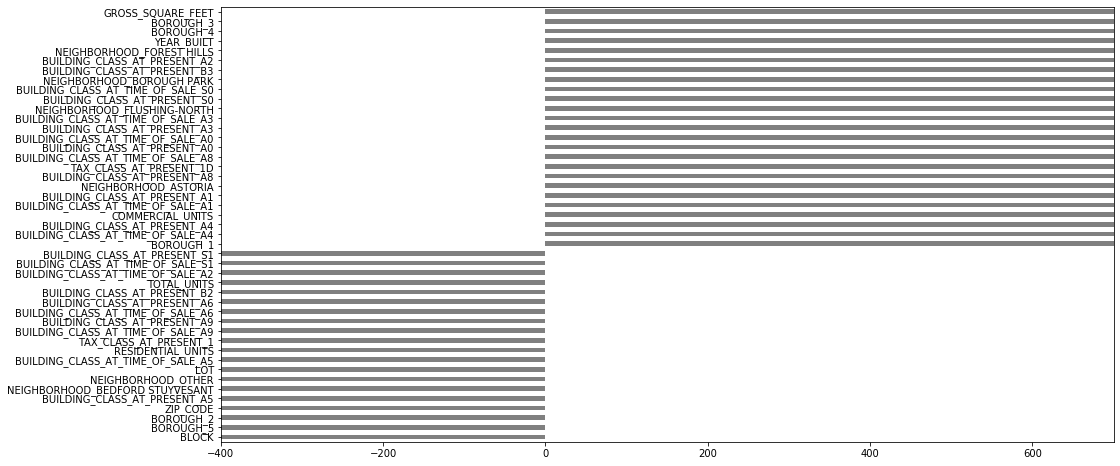

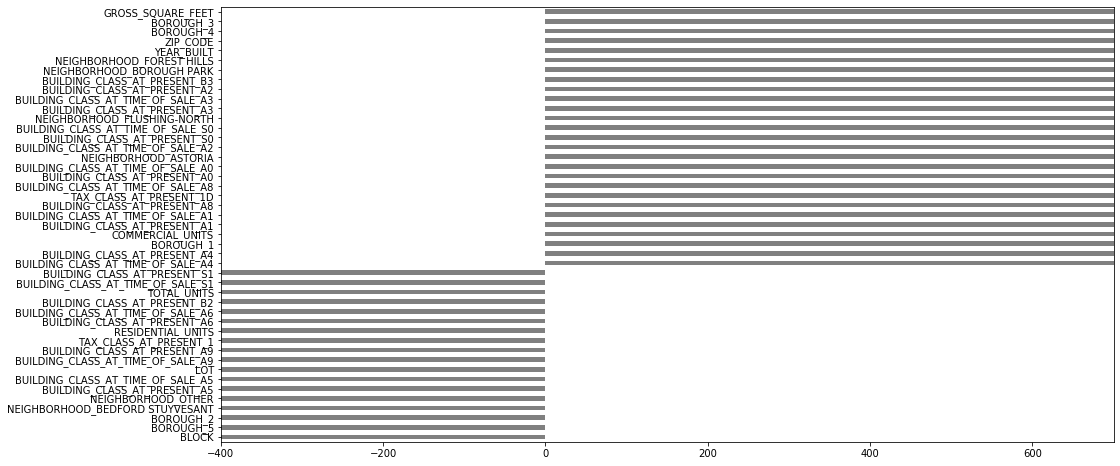

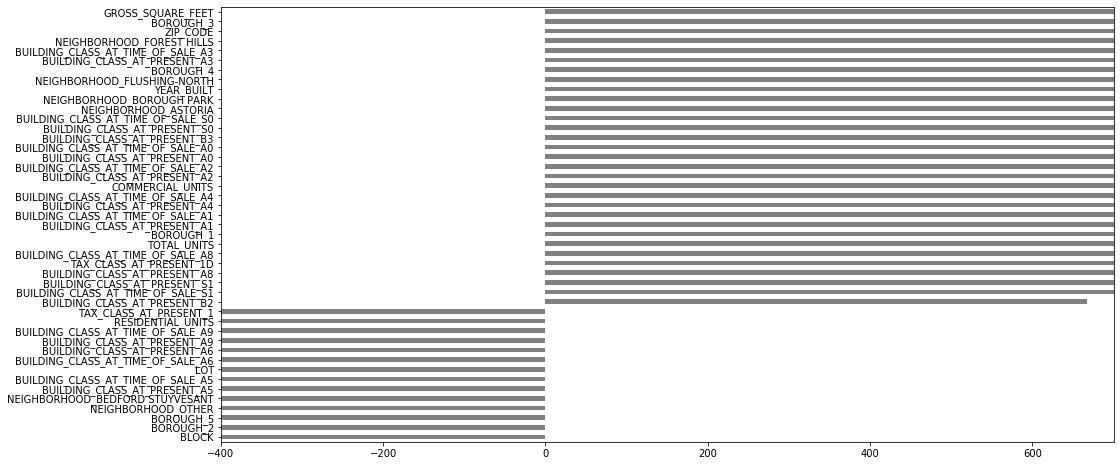

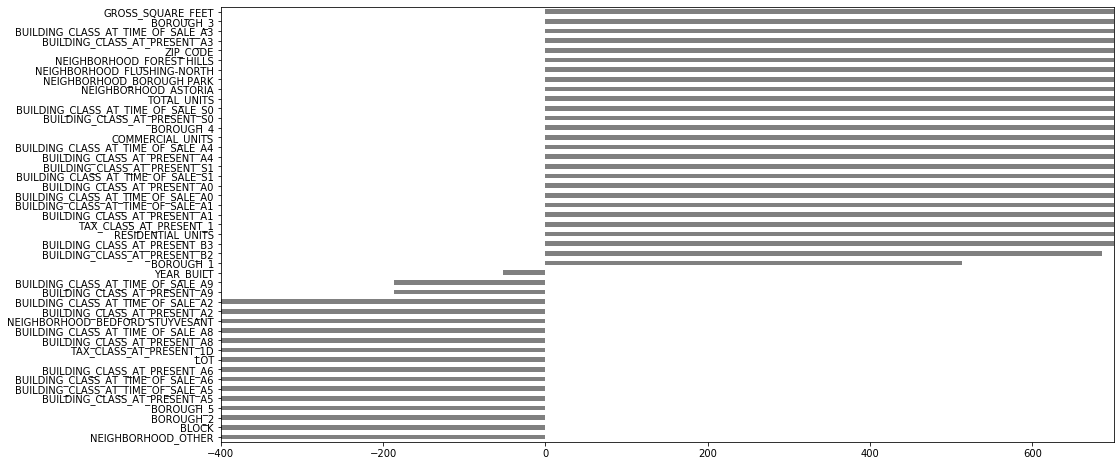

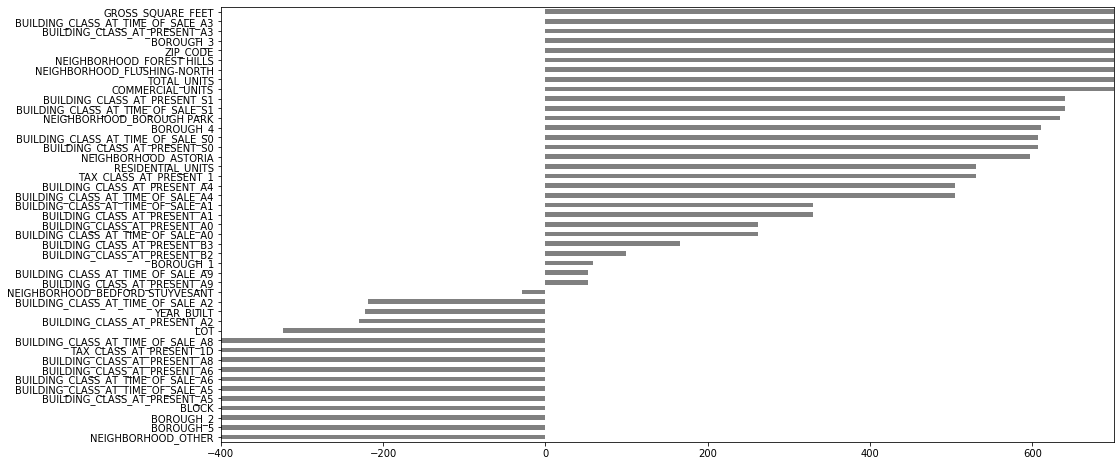

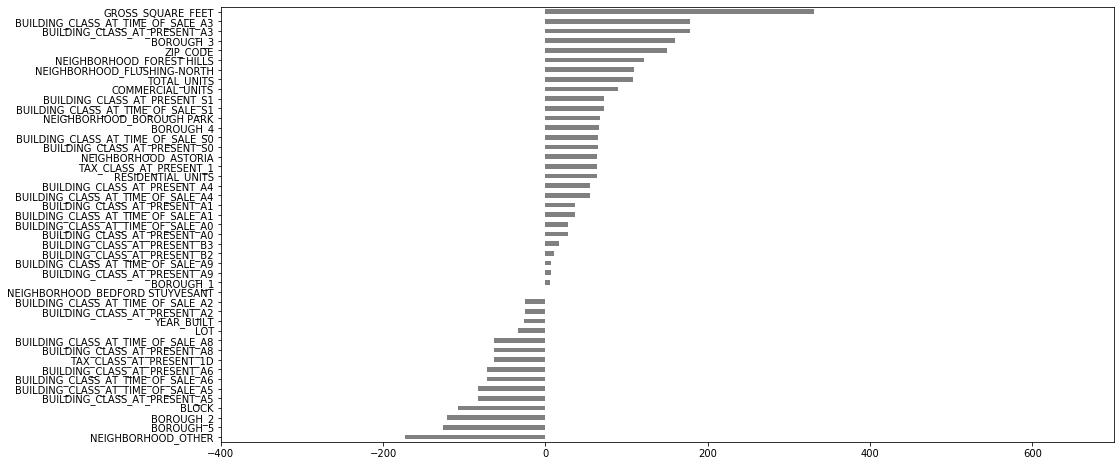

In [31]:
# Try a range of alpha parameters for Ridge Regression.
for alpha in [10**1,10**2,10**3,10**4,10**5,10**6]:

    # Scale data before doing Ridge Regression
    scalar = StandardScaler()
    X_train_scaled = scalar.fit_transform(X_train)
    X_test_scaled = scalar.transform(X_test)
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression,with alpha={alpha}')) 
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Get test MAE
    mae = mean_absolute_error(y_test,y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-400,700)
    plt.show()

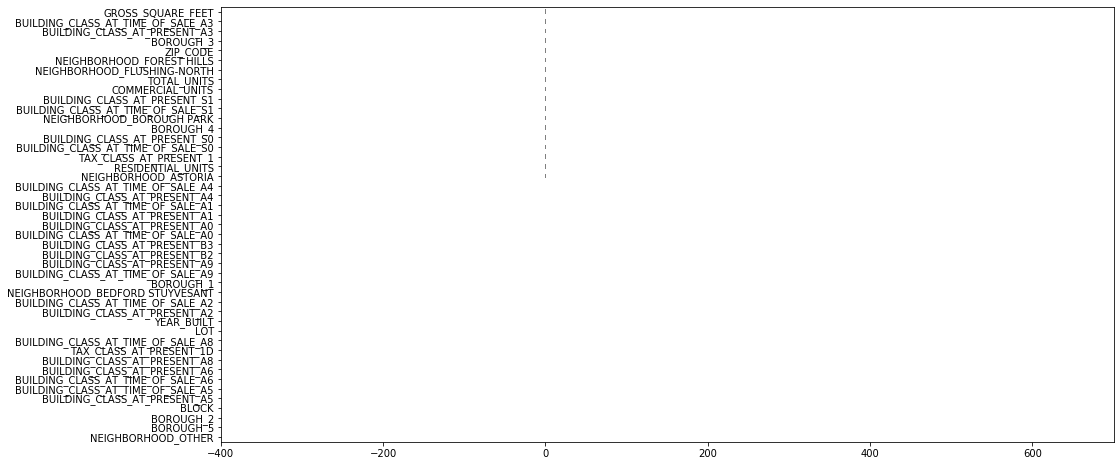